## Deep-Learning Particle Filter
The goal of this project is to explore the idea of using machine-learning to learn the physical behavior of complexe systems and use these models as the "physical-update" in a particle filter to do state estimation.

In order to develop this new technique, a numerical experiment is devised: the first attempt involves simulating a double-pendulum and using the afore-mentioned technique of deep-learning particle filtering in order to estimate the position of the entire pendulum (in this case the angle $\beta$) depending on the measurement of the angle of the first link.
![Double Pendulum](img/DoublePendulum.png "Double Pendulum")

## Steps for the Project:
1. Set up a simulator for a double pendulum
2. Plot alpha and beta for a set of initial conditions
3. Train an LSTM network on the variables $\alpha$, $\dot{\alpha}$ and see to what extent $\beta$ can be predicted. If this does not work, one could also train the network on $\alpha$, $\dot{\alpha}$, and $\dot{\beta}$ and see how that works.

### First Step: a Double Pendulum Simulator:
Here we work with existing code to give a head-start, in particular we use the code from [this link](https://github.com/chris-greening/double-pendula). From this work, we plot the angle values. The following cell is copied directly. Afterwards, the code is adapted to our particular use.

In [1]:
#Author: Chris Greening
#Date: 7/15/19
#Purpose: Another crack at the double pendulum to convert it to OOP
#to support multiple pendula

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from numpy import sin, cos
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML # Added by OCornes for Jupyter  compatibility

fig = plt.figure()

class System:
    def __init__(self):
        self.double_pendulums = []

    def add_double_pendulum(self, double_pendulum):
        pass

class DoublePendulum:
    def __init__(
            self, 
            L1=1, 
            L2=1, 
            m1=1, 
            m2=1, 
            g=-9.81,
            y0=[90, 0, -10, 0],
            tmax = 180,
            dt = .05,
            color = "g"
        ):

        self.tmax = tmax
        self.dt = dt
        self.t = np.arange(0, self.tmax+self.dt, self.dt)
        self.color = color
        self.g = g
        self.pendulum1 = Pendulum(L1, m1)
        self.pendulum2 = Pendulum(L2, m2)
        
        # Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
        self.y0 = np.array(np.radians(y0))

        # Do the numerical integration of the equations of motion
        self.y = odeint(self.derivative, self.y0, self.t, args=(self.pendulum1.L, self.pendulum2.L, self.pendulum1.m, self.pendulum2.m))

        self.pendulum1.calculate_path(self.y[:, 0])
        self.pendulum2.calculate_path(self.y[:, 2], self.pendulum1.x, self.pendulum1.y)

        self.w = self.y[:, 1]

        self.fig = fig
        self.ax_range = self.pendulum1.L + self.pendulum2.L
        self.ax = self.fig.add_subplot(111, autoscale_on=False, xlim=(-self.ax_range, self.ax_range), ylim=(-self.ax_range, self.ax_range))
        self.ax.set_aspect('equal')
        self.ax.grid()

        self.pendulum1.set_axes(self.ax)
        self.pendulum2.set_axes(self.ax)

        self.line, = self.ax.plot([], [], 'o-', lw=2,color=self.color)
        self.time_template = 'time = %.1fs'
        self.time_text = self.ax.text(0.05, 0.9, '', transform=self.ax.transAxes)

    def derivative(self, y, t, L1, L2, m1, m2):
        """Return the first derivatives of y = theta1, z1, theta2, z2."""
        theta1, z1, theta2, z2 = y

        c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

        theta1dot = z1
        z1dot = (m2*self.g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
                (m1+m2)*self.g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
        theta2dot = z2
        z2dot = ((m1+m2)*(L1*z1**2*s - self.g*np.sin(theta2) + self.g*np.sin(theta1)*c) + 
                m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
        return theta1dot, z1dot, theta2dot, z2dot

    def init(self):
        self.line.set_data([], [])
        self.time_text.set_text('')
        return self.line, self.time_text

class Pendulum:
    def __init__(self, L, m):
        self.L = L
        self.m = m

    def set_axes(self, ax):
        self.ax = ax

        # defines line that tracks where pendulum's have gone
        self.p, = self.ax.plot([], [], color='r-')
        self.w = self.ax.plot([], [])

    def calculate_path(self, y, x0=0, y0=0):
        self.x = self.L*np.sin(y) + x0
        self.y = self.L*np.cos(y) + y0

def animate(i):
    arr = pendula #pendulum2, pendulum3, pendulum4, pendulum5, pendulum6]
    return_arr = []
    for double_pendulum in arr:
        thisx = [0, double_pendulum.pendulum1.x[i], double_pendulum.pendulum2.x[i]]
        thisy = [0, double_pendulum.pendulum1.y[i],
                          double_pendulum.pendulum2.y[i]]
        
        double_pendulum.line.set_data(thisx, thisy)
        double_pendulum.time_text.set_text(double_pendulum.time_template % (i*double_pendulum.dt))

        return_arr.append(double_pendulum.line)
        return_arr.append(double_pendulum.time_text)
        return_arr.append(double_pendulum.pendulum1.p)
        return_arr.append(double_pendulum.pendulum2.p)

    return return_arr

def random_hex():
    
    hex_chars = "0123456789ABCDEF"
    
    hex_string = "#"
    for i in range(6):
        index = np.random.randint(0, len(hex_chars))
        hex_string += hex_chars[index]

    return hex_string
        
L1 = 5
L2 = 5

pendula = []
initial_dtheta = 0
initial_theta = 90
dtheta = .5

#creates pendula 
for _ in range(10):
    pendula.append(DoublePendulum(L1=L1,L2=L2,y0=[initial_theta-initial_dtheta, 0,-10,0], tmax=15, color=random_hex()))
    initial_dtheta += dtheta

# plt.plot(pendula[0].x2, pendula[0].y2, color=pendula[0].color)

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(pendula[0].y)),
                            interval=25, blit=True, init_func=pendula[0].init)

ani.save('line.gif', dpi=80, writer='imagemagick')

# HTML(ani.to_html5_video())

# plt.show() # removed by OCornes for Jupyter adaptation

/home/olivier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


## Notes on observability:

Before we can attempt to apply deep-learning on the double pendulum usefull, it is important to **determine if the system of our experiement is observable**. If it is not observable, i.e. the information necessary for estimating the variable of interest is not available in any way, then the experiment needs to be redesigned.

Determining the observability of a non-linear system like the double pendulum requires techniques which use Lie derivatives. These techniques are complexe, and a proper execution of these is presently difficult, so instead we chose to **linearise the system around a chosen operating point (or a series of points), and build the experiment based on that.** The proper method to derive observability will be done subsequently, if the results on the deep learning experiment turn out promising.

### Observability for linear systems: reminder of the basic steps:

(From Wikipedia) For time-invariant linear systems in the state space representation, there are convenient tests to check whether a system is observable. Consider a SISO system with $n$ state variables (see state space for details about MIMO systems) given by 

$\dot{x} = Ax + Bu$

$y       = Cx + Du$

With $\vec{x}$ being the state vector, $\vec{y}$ the output vector and $u$ the input vector.

If the rank of the observability matrix of the system is $n$, then the system is observable.

The observability matrix for a linear system is:

$O = \begin{bmatrix} C \\ CA \\ CA^2 \\ ... \\ CA^{n-1}\end{bmatrix}$

### Linearising the double pendulum:

Physical model of the double pendulum:

$\vec{x} = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix} = \begin{bmatrix} \theta_1 \\ \dot{\theta_1} \\ \theta_2 \\ \dot{\theta_2} \end{bmatrix}$

$\vec{\dot{x}} = \begin{bmatrix} x_2 \\ \frac{1}{L_1 (m_1 + m_2\sin(x_1-x_3)^2)} \left(m_2g\sin(x_3)\cos(x_1 - x_3) - m_2\sin(x_1 - x_3)\left( L_1 x_2^ 2 \cos(x_1-x_3) + L_2 x_4^2\right) - (m_1 + m_2)g\sin(x_1) \right)\\ x_4 \\ \frac{1}{L_2 (m_1 + m_2\sin(x_1-x_3)^2)} \left((m_1 + m_2)L_1 x_2^2\sin(x_1-x_3) - g\sin(x_3) + g\sin(x_1)\cos(x_1-x_3) + m_2 L_2 x_4^2 \sin(x_1-x_3)\cos(x_1- x_3) \right) \end{bmatrix}$


$\vec{y} = \begin{bmatrix} x_1 \\ x_3 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0\\0 & 0 & 1 & 0\end{bmatrix} \vec{x}$

### Jacobian of the system:
We use Wolfram Alpha in order to derive the derivatives of the dynamics equations. The Jacobian has the following for in this case:

$A = \frac{\partial \vec{\dot{x}}}{\vec{x}} = 
\begin{bmatrix} 
0      & 1      & 0      & 0 \\
a_{21} & a_{22} & a_{23} & a_{24}\\
0      & 0      & 0      & 1 \\
a_{41} & a_{42} & a_{43} & a_{44}\\
\end{bmatrix}
$

$a_{22} = \frac{-2m_2\sin(x_1-x_3)\cos(x_1-x_3)}{m_1 + m_2\sin(x_1-x_3)^2}x_2$

$a_{24} = \frac{L2}{L1}\frac{-2m_2\sin(x_1-x_3)}{m_1 + m_2\sin(x_1-x_3)^2}x_4$

$a_{42} = \frac{L1}{L2}\frac{2(m_1 + m_2)\sin(x_1-x_3)}{m_1 + m_2\sin(x_1-x_3)^2}x_2$

$a_{44} = \frac{2m_2\sin(x_1-x_3)\cos(x_1-x_3)}{m_1 + m_2\sin(x_1-x_3)^2}x_4$

## Notes on machine learning for dynamical systems:


In [11]:
#==================================================================
# Attempt for numerical differentiation of the system using python:
#==================================================================
import numpy as np
g = 9.81
# From the double pendulum python script:

#def derivative(y, t, L1, L2, m1, m2):
def derivative(y, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
            (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
            m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

# A = [[df1/dx1, df1/dx2, ...df1/dxN],[df2/dx1, df2/dx2, ...] ...[dfN/dx1, dfN/dx2, ... dfN/dxN]]
# Testing derivative techniques for a single dfi/dxj:
y   = [0, 0, 0, 0]
eps = 1e-6;
y_  = y.copy()
y_[1] += eps 
L1  = 1;
L2  = 1;
m1  = 1;
m2  = 1; 

theta1dot,  z1dot,  theta2dot,  z2dot  = derivative(y,  L1, L2, m1, m2)
theta1dot_, z1dot_, theta2dot_, z2dot_ = derivative(y_, L1, L2, m1, m2)

print('Vector:')
print('theta1dot: '+ str(theta1dot_-theta1dot))
print('z1dot_: '+ str(z1dot_-z1dot))
print('theta2dot_: '+ str(theta2dot_-theta2dot))
print('z2dot_: '+ str(z2dot_-z2dot)) 
print(y_)
print(y)

Vector:
theta1dot: 1e-06
z1dot_: 0.0
theta2dot_: 0
z2dot_: 0.0
[0, 1e-06, 0, 0]
[0, 0, 0, 0]


In [12]:
# Numerical derivation function:
def d_double_pendulum(y, L1, L2, m1, m2, eps):
    
    jacobian = np.zeros((4,4))
    
    for i in range(4):
        y1, y2     = y.copy(), y.copy()
        y2[i] += eps/2
        y1[i] -= eps/2 
        
        theta1dot2, z1dot2, theta2dot2, z2dot2 = derivative(y2, L1, L2, m1, m2)
        theta1dot1, z1dot1, theta2dot1, z2dot1 = derivative(y1, L1, L2, m1, m2)
        
        dtheta1dot = (theta1dot2-theta1dot1)/eps
        dz1dot     = (z1dot2-z1dot1)/eps
        dtheta2dot = (theta2dot2-theta2dot1)/eps
        dz2dot     = (z2dot2-z2dot1)/eps
        
        jacobian[:,i] = [dtheta1dot, dz1dot, dtheta2dot, dz2dot]
    

    return jacobian

'''
def printJacobian(jacobian):
    for i in range(len(jacobian)):
        for j in range(len(jacobian)):
            print(round(jacobian[i][j],2),end=" ")
        print("\n")'''

def printJacobian(jacobian):
    for i in range(len(jacobian)):
        print('{:^10}{:^10}{:^10}{:^10}'.format(round(jacobian[i][0],2), round(jacobian[i][1],2), round(jacobian[i][2],2), round(jacobian[i][3],2)))
        
jacobian = d_double_pendulum(y, L1, L2, m1, m2, eps)
printJacobian(jacobian)
print(jacobian)

   0.0       1.0       0.0       0.0    
  -19.62     0.0       9.81      0.0    
   0.0       0.0       0.0       1.0    
  19.62      0.0      -19.62     0.0    
[[  0.     1.     0.     0.  ]
 [-19.62   0.     9.81   0.  ]
 [  0.     0.     0.     1.  ]
 [ 19.62   0.   -19.62   0.  ]]


In [13]:
rank = np.linalg.matrix_rank(jacobian)

A = np.array(jacobian)
A2= np.dot(A,A) 
A3= np.dot(A,A2) 
#A2= A*A
#A3= A*A2
#C  = np.array([[1,0,0,0],[0,0,1,0]])
C  = np.array([[1,0,0,0]])
CA = np.dot(C,A) 
CA2= np.dot(C,A2) 
CA3= np.dot(C,A3) 

O = np.vstack((C,CA))
O = np.vstack((O,CA2))
O = np.vstack((O,CA3))

print(C)
print(O)
print(np.linalg.matrix_rank(O))

[[1 0 0 0]]
[[  1.     0.     0.     0.  ]
 [  0.     1.     0.     0.  ]
 [-19.62   0.     9.81   0.  ]
 [  0.   -19.62   0.     9.81]]
4


In [14]:
# Bro, kuck mal den Rank an:
print(np.linalg.matrix_rank(O))

4


## Simulating a noisy double pendulum
The goal of this section is to produce raw data from the simulation that can be fed into the neural net for learning. First, the data is extracted for a 10 second simulation for a single initial condition. We plot this on x-t plots, and possibly in the state space $x_1, x_2, x_3$ as a 3D trajectory.

From there, we generate 10 second simulations for a variety of initial conditions and save it in csv format for the input to the neural nets.

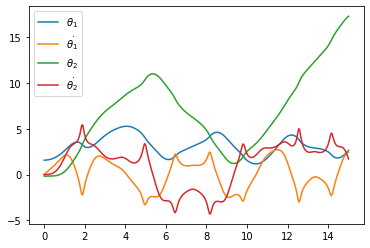

In [9]:
# Pendulum simulator:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from numpy import sin, cos
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class DoublePendulum:
    def __init__(
            self, 
            L1=1, 
            L2=1, 
            m1=1, 
            m2=1, 
            g=-9.81,
            y0=[90, 0, -10, 0],
            tmax = 180,
            dt = .05,
            color = "g"
        ):

        self.tmax = tmax
        self.dt = dt
        self.t = np.arange(0, self.tmax+self.dt, self.dt)
        self.color = color
        self.g = g
        self.pendulum1 = Pendulum(L1, m1)
        self.pendulum2 = Pendulum(L2, m2)
        
        # Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
        self.y0 = np.array(np.radians(y0))

        # Do the numerical integration of the equations of motion
        self.y = odeint(self.derivative, self.y0, self.t, args=(self.pendulum1.L, self.pendulum2.L, self.pendulum1.m, self.pendulum2.m))

        self.pendulum1.calculate_path(self.y[:, 0])
        self.pendulum2.calculate_path(self.y[:, 2], self.pendulum1.x, self.pendulum1.y)

        '''self.w = self.y[:, 1]

        self.fig = fig
        self.ax_range = self.pendulum1.L + self.pendulum2.L
        self.ax = self.fig.add_subplot(111, autoscale_on=False, xlim=(-self.ax_range, self.ax_range), ylim=(-self.ax_range, self.ax_range))
        self.ax.set_aspect('equal')
        self.ax.grid()

        self.pendulum1.set_axes(self.ax)
        self.pendulum2.set_axes(self.ax)

        self.line, = self.ax.plot([], [], 'o-', lw=2,color=self.color)
        self.time_template = 'time = %.1fs'
        self.time_text = self.ax.text(0.05, 0.9, '', transform=self.ax.transAxes)'''

    def derivative(self, y, t, L1, L2, m1, m2):
        """Return the first derivatives of y = theta1, z1, theta2, z2."""
        theta1, z1, theta2, z2 = y

        c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

        theta1dot = z1
        z1dot = (m2*self.g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
                (m1+m2)*self.g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
        theta2dot = z2
        z2dot = ((m1+m2)*(L1*z1**2*s - self.g*np.sin(theta2) + self.g*np.sin(theta1)*c) + 
                m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
        return theta1dot, z1dot, theta2dot, z2dot

    def init(self):
        self.line.set_data([], [])
        self.time_text.set_text('')
        return self.line, self.time_text

class Pendulum:
    def __init__(self, L, m):
        self.L = L
        self.m = m

    def set_axes(self, ax):
        self.ax = ax

        # defines line that tracks where pendulum's have gone
        self.p, = self.ax.plot([], [], color='r-')
        self.w = self.ax.plot([], [])

    def calculate_path(self, y, x0=0, y0=0):
        self.x = self.L*np.sin(y) + x0
        self.y = self.L*np.cos(y) + y0

def animate(i):
    arr = pendula #pendulum2, pendulum3, pendulum4, pendulum5, pendulum6]
    return_arr = []
    for double_pendulum in arr:
        thisx = [0, double_pendulum.pendulum1.x[i], double_pendulum.pendulum2.x[i]]
        thisy = [0, double_pendulum.pendulum1.y[i], double_pendulum.pendulum2.y[i]]
        
        double_pendulum.line.set_data(thisx, thisy)
        double_pendulum.time_text.set_text(double_pendulum.time_template % (i*double_pendulum.dt))

        return_arr.append(double_pendulum.line)
        return_arr.append(double_pendulum.time_text)
        return_arr.append(double_pendulum.pendulum1.p)
        return_arr.append(double_pendulum.pendulum2.p)

    return return_arr

def random_hex():
    
    hex_chars = "0123456789ABCDEF"
    
    hex_string = "#"
    for i in range(6):
        index = np.random.randint(0, len(hex_chars))
        hex_string += hex_chars[index]

    return hex_string

L1 = 5
L2 = 5

pendula = []
initial_dtheta = 0
initial_theta = 90
dtheta = .5

dp = DoublePendulum(L1=L1,L2=L2,y0=[initial_theta-initial_dtheta, 0,-10,0], tmax=15, color=random_hex())
t          = dp.t
theta1     = dp.y[:,0]
theta1_dot = dp.y[:,1]
theta2     = dp.y[:,2]
theta2_dot = dp.y[:,3]

# plot lines
plt.plot(t, theta1, label = r"$\theta_1$")
plt.plot(t, theta1_dot, label = r"$\dot{\theta_1}$")
plt.plot(t, theta2, label = r"$\theta_2$")
plt.plot(t, theta2_dot, label = r"$\dot{\theta_2}$")
plt.legend()
plt.show()

# References:

1. [Double Pendulum Equations](http://www.maths.surrey.ac.uk/explore/michaelspages/documentation/Double.pdf)

2. [ESTIMATION AND CONTROL OF A DOUBLE-INVERTED PENDULUM](https://core.ac.uk/download/pdf/161989454.pdf)

3. [Control Theory: The Double Pendulum Inverted
on a Cart](https://digitalrepository.unm.edu/cgi/viewcontent.cgi?article=1131&context=math_etds)